In [1]:
pip install phik shap;

Note: you may need to restart the kernel to use updated packages.


# Проект, который поможет оператору связи «ТелеДом» бороться с оттоком клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. 
  
Компания «ТелеДом» предоставляет широкий спектр услуг связи, включая стационарную телефонию с возможностью подключения нескольких линий, а также высокоскоростной интернет через DSL и оптоволокно. Дополнительно клиентам доступны услуги интернет-безопасности, техподдержки, облачного хранилища данных и стриминга контента.

**Цель данного проекта** — разработать и обучить модель машинного обучения, которая сможет с высокой точностью предсказывать риск оттока клиентов «ТелеДома». Процесс включает в себя первоначальный осмотр и предобработку предоставленных данных, глубокий анализ признаков для выявления закономерностей, связанных с уходом клиентов, и, наконец, проектирование и валидацию модели, способной эффективно определять абонентов с высокой вероятностью отказа от услуг.

**План проекта:**

[**1 Первый взгляд на данные и обработка**](#1)  
[1.1 Первый взгляд на данные](#2)  
[1.2 Предобработка данных](#3)  
[1.3 Объединение данных](#4)  
  
[**2 Анализ признаков и добавление новых**](#5)  
[2.1 Создание функций](#6)  
[2.2 Анализ распределения признаков](#7)  
[2.3 Исследование корреляций](#8)  
[2.4 Разделение данных на выборки, кодирование и масштабирование признаков.](#9)  
  
[**3 Обучение моделей МО**](#10)  
[3.1 Обучение трех моделей МО](#11) 
[3.2 Проверка выбранной модели на тестовых данных](#12)  
[3.3 Анализ и интерпретация важности признаков](#13)  
[3.4 Интерпретация матрицы ошибок](#14)  
  
[**Вывод**](#15)

In [2]:
# Импорт нужных библиотек
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from catboost import CatBoostClassifier
import shap
import seaborn as sns
import warnings

In [3]:
#Ограничим вывод warnings
warnings.filterwarnings('ignore')

## Первый взгляд на данные и обработка
<a id='1'></a>

В этом разделе будет описываться первое знакомство с данными. Мы откроем данные, изучим таблицы, обработаем и соединим их в одну. Данный раздел состоит из трех этапов:
- Первый взгляд на данные. Здесь мы откроем данные и изучим информацию о них.
- Предобработка данных. Здесь мы обработаем все проблемы датасетов.
- Создание итоговой таблицы. Тут мы создадим одну общую таблицу.

### Первый взгляд на данные
<a id='2'></a>

Данные состоят из нескольких файлов, полученных из разных источников:

- ``contract_new.csv`` — информация о договоре;
- ``personal_new.csv`` — персональные данные клиента;
- ``internet_new.csv`` — информация об интернет-услугах;
- ``phone_new.csv`` — информация об услугах телефонии.

Файл ``contract_new.csv``

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл ``personal_new.csv``

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл ``internet_new.csv``

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл ``phone_new.csv``

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Импортируем нужные датасеты и добавим их в один массив для облегчения первичного анализа.

In [4]:
contract_new = pd.read_csv("datasets/contract_new.csv")
personal_new = pd.read_csv("datasets/personal_new.csv")
internet_new = pd.read_csv("datasets/internet_new.csv")
phone_new = pd.read_csv("datasets/phone_new.csv")

In [5]:
# Создадим массив со всеми датасетами
datasets = [contract_new, personal_new, internet_new, phone_new]

Взглянем на данные и выведем общую информацию о датасетах:

In [6]:
for data in datasets:
    display(data.head(5))
    display(data.info())
    duplicates = data.duplicated(subset='customerID', keep=False)

    # Подсчет количества дубликатов
    number_of_duplicates = duplicates.sum()
    print(f"Количество дубликатов id: {number_of_duplicates}")

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

Количество дубликатов id: 0


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

Количество дубликатов id: 0


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

Количество дубликатов id: 0


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

Количество дубликатов id: 0


В первом и втором датасетах есть небольшие проблемы:
- Неправильный тип столбцов **BeginDate** и **EndDate**. Так как в этих столбцах хранится информация о времени, их тип стоит заменить на ``datetime``
- Неправильный тип столбца **TotalCharges**. Так как этот признак количественный, и отвечает он за общие выплаты, его нужно заменить на ``float``.
- В столбце **EndDate** встречаются значения ``no``. Это означает, что клиенты, на момент выгрузки данных, не отписались от сервиса. Поэтому заполним эти значения датой выгрузки датасета - 1 февраля 2020 года.
- В датасете о клиентах признак ``SeniorCitizen`` является категориальным, поэтому его можно перевести в строчный тип

### Предобработка данных
<a id='3'></a>

In [7]:
# Изменим типы столбцов в BeginDate и EndDate
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate']).dt.normalize()
contract_new['EndDate'] = contract_new['EndDate'].replace('No', '2020-02-01')
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate']).dt.normalize()

# Изменим тип столбца TotalCharges
contract_new['TotalCharges'] = pd.to_numeric(contract_new['TotalCharges'], errors='coerce')

# Меняем тип столбца SeniorCitizen на obj
personal_new['SeniorCitizen'] = personal_new['SeniorCitizen'].astype('object')

Проверим изменения в этом датасете:

In [8]:
display(contract_new.head(5))
display(contract_new.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


None

В столбце ``TotalCharges`` появились пропущенные значения, посмотрим на них:

In [9]:
contract_new[contract_new['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN


У выведенной таблицы видно, что начало подписки совпадает с датой выгрузки датасета. Теперь понятно, что пропуски появились в данных т.к. эти пользователи еще не успели ничего заплатить. Обработаем эти значения: заполним их нулем.

In [10]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].fillna(0)

In [11]:
display(contract_new.head(5))
display(contract_new.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


None

Данные обработаны.

Промежуточные результаты:
- Проблемы в данных были только в первом датасете
- дубликаты в данных обнаружены не были
- Типы столбцов **BeginDate** и **EndDate** были заменены на ``datetime``
- Тип столбца **TotalCharges** был заменен на ``float``.
- В столбце **EndDate** значения ``no`` были обработаны и заменены значением даты выгрузки датасета
- В столбце с общими выплатами были обнаружены и обработаны пропуски. Они возникли т.к. на момент выгрузки датасета эти клиенты еще не успели ничего заплатить.

### Объединение данных
<a id='4'></a>

Для построения модели и последующего анализа, потребуется создать одну общую таблицу со всеми признаками. 

  Создадим одну общую таблицу из всех признаков и добавим в нее новый - бинарный признак классификации клиентов. Новый признак возьмем из **EndDate**. Если дата окончания контракта известна, то поставим значение **1**, иначе - **0**.

  Датасеты объеденим по ``customerID``. Будем отталкиваться от датасета ``personal_new`` т.к. в нем хранятся все **id**.

In [12]:
all_data = pd.merge(personal_new, contract_new, on='customerID', how='left')
all_data = pd.merge(all_data, internet_new, on='customerID', how='left')
all_data = pd.merge(all_data, phone_new, on='customerID', how='left')

#Сделаем колонку customerID индексом:
all_data.set_index('customerID', inplace=True)

Добавим новый признак(так как он категориальный переведем в строку):

In [13]:
all_data['is_canceled'] = np.where(all_data['EndDate'] == '2020-02-01', 1, 0)
all_data['is_canceled'] = all_data['is_canceled'].astype('object')

Заполним пропуски в столбцах **OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, InternetService и MultipleLines** на значения ``None`` поскользу де факто, пропуск в этих столбцах обозначает отсутсвие какой-то из основных услуг. Заполнить эти значения на ``No`` было бы не правильно т.к. это нарушило бы логику в датасете.

In [14]:
columns_with_options = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService', 'MultipleLines']
for column in columns_with_options:
    all_data[column].fillna('None', inplace=True)

Посмотрим на получившийся датасет:

In [15]:
display(all_data.head(5))
display(all_data.info())

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,is_canceled
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,None,1
5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,1
3668-QPYBK,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,1
7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,None,1
9237-HQITU,Female,0,No,No,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,1


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   object        
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   datetime64[ns]
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   float64       
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtecti

None

Таблицы объединились правильно. Можно приступать к исследовательскому анализу.

**Промежуточные результаты:**
- Данные были объединены в одну таблицу по индексам.
- Объединение было с учетом всех индексов из таблицы ``personal_new`` т.к. в ней хранятся все данные о клиентах.
- Получилась таблица с информацией по всем клиентам.

## Анализ признаков и добавление новых
<a id='5'></a>

Для того, чтобы обнаружить интересные зависимости в данных или аномалии, мы проведем анализ распределения признаков в датасете. 
Данный раздел состоит из трех этапов:
- Создание функций. Здесь мы создаем нужные функции для дальнейшего исследования
- Анализ распределения признаков. Для количественных признаков построим гистограммы, а для категориальных круговые диаграммы. Отдельно также исследуем времянные ряды
- Анализ корреляций в признаках
- Разделение выборок, кодирование и масштабирование признаков

### Создание функций
<a id='6'></a>

Создадим четыре функции: 
- для построения гистограммы с количественными признаками 
- для построения круговой диагрыммы с категориальными признаками.
- для ящика с усами
- функцию для временных рядов

In [16]:
#функция для гистограммы
def make_hist(data, column, xlabel, ylabel, num_bins = 50, show_title=True, condition=None, condition_column=None, condition_label=None):
    if condition == None:
        plt.hist(data[column], bins=num_bins)
    else:
        plt.hist(data[data[condition_column]==condition][column], alpha=0.5, bins=num_bins, label=condition_label, density=True)
        
        
    if show_title == True:
        plt.title(f'Распределение {column}')
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

Эта функция строит гистограмму для заданного столбца DataFrame.  

Параметры:
- data (DataFrame): Набор данных, в котором содержится столбец для анализа.
- column (str): Имя столбца в DataFrame, для которого нужно построить гистограмму.
- xlabel (str): Название для оси X на графике.
- ylabel (str): Название для оси Y на графике.
- num_bins (int, опционально): Количество корзин гистограммы, по умолчанию 50.
- show_title (bool, опционально): Флаг, указывающий, нужно ли показывать заголовок графика, по умолчанию True.
- condition (various, опционально): Значение условия, по которому фильтруются данные перед построением гистограммы.
- condition_column (str, опционально): Имя столбца, по которому применяется фильтрация.
- condition_label (str, опционально): Лейбл для условия, который будет отображаться в легенде.

In [17]:
#функция для круговой диаграммы
def make_pie(data, column, show_title=True, title=f'Процентное соотношение категорий в {column}'):
    plt.figure(figsize=(10, 5))
    category_counts = Counter(data[column])

    # Подготовка данных для круговой диаграммы
    labels = category_counts.keys()
    sizes = category_counts.values()

    # Создание круговой диаграммы
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    if show_title == True:
        plt.title(title)
    plt.show()

Эта функция строит круговую диаграмму для заданного столбца DataFrame.

Параметры:
- data (DataFrame): Набор данных, в котором содержится столбец для анализа.
- column (str): Имя столбца в DataFrame, для которого нужно построить круговую диаграмму.
- show_title (bool, опционально): Флаг, указывающий, нужно ли показывать заголовок графика, по умолчанию True.


In [18]:
def make_boxplot(data, column, show_title=True):
    plt.figure(figsize=(10, 5))
    plt.boxplot(data[column])
    plt.ylabel('Значения')
    plt.xlabel('Распределение')
    if show_title == True:
        plt.title(f'Ящик с усами для {column}')
    plt.show()
    
    print(data[column].describe())

Эта функция создаёт график "ящик с усами" (boxplot) для заданного столбца DataFrame.

Параметры:
- data (DataFrame): Набор данных, в котором содержится столбец для анализа.
- column (str): Имя столбца в DataFrame, для которого нужно построить ящик с усами.
- show_title (bool, опционально): Флаг, указывающий, нужно ли показывать заголовок графика, по умолчанию True.


In [19]:
# функция для временного ряда
def decompose_time_series(data, date_col, value_col, start_date, end_date, ylabel_1, ylabel_2, ylabel_3, ylabel_4, x_label, model='additive', period=None):

    data[date_col] = pd.to_datetime(data[date_col])
    data.set_index(date_col, inplace=True)
    data = data[start_date:end_date].resample('1M').sum()

    # Выполняем декомпозицию
    decomposition = seasonal_decompose(data[value_col], model=model, period=period)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 8))
    plt.suptitle('Декомпозиция временного ряда', fontsize=16)

    plt.subplot(411)
    plt.plot(data[value_col], label='Оригинал')
    plt.legend(loc='best')
    plt.ylabel(ylabel_1)

    plt.subplot(412)
    plt.plot(trend, label='Тренд')
    plt.legend(loc='best')
    plt.ylabel(ylabel_2)

    plt.subplot(413)
    plt.plot(seasonal, label='Сезонность')
    plt.legend(loc='best')
    plt.ylabel(ylabel_3)

    plt.subplot(414)
    plt.plot(residual, label='Остатки')
    plt.legend(loc='best')
    plt.ylabel(ylabel_4)
    plt.xlabel(x_label)

    plt.tight_layout()
    plt.show()

Эта функция нужна для декомпозиции временного ряда на тренд, сезонность и остатки.

Параметры:
- data (DataFrame): DataFrame, содержащий данные.
- date_col (str): Имя столбца с датами.
- value_col (str): Имя столбца со значениями временного ряда.
- model (str): Тип модели декомпозиции ('additive' или 'multiplicative').
- period (int): Число временных интервалов в сезоне.

Функции созданы, можно приступать к исследовательской работе

### Анализ распределения признаков
<a id='7'></a>

**Изучим распределения всех признаков в датасете.**

Посмотрим на распределение **пола клиентов**:

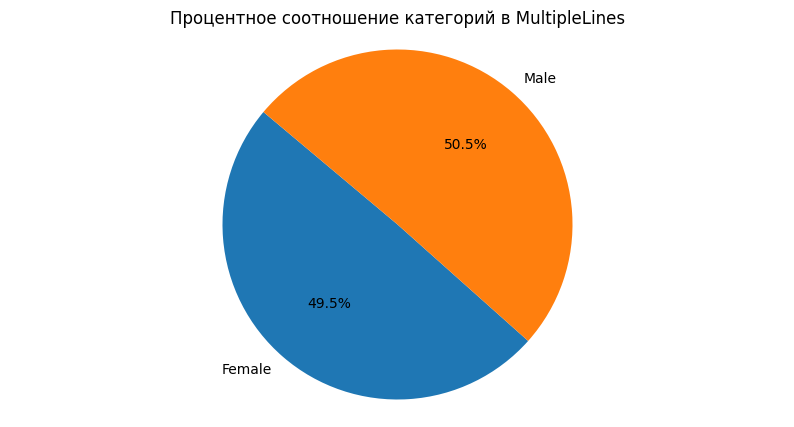

In [20]:
make_pie(all_data, 'gender')

**Результат:**

  Судя по круговой диаграмме, распределение пола клиентов равное. Этот результат был ожидаем, если бы какой-то категории было больше, это бы явно указывало на какую-то взаимосвязь или ошибку. 


Дальше посмотрим на распределение признака **SeniorCitizen**:

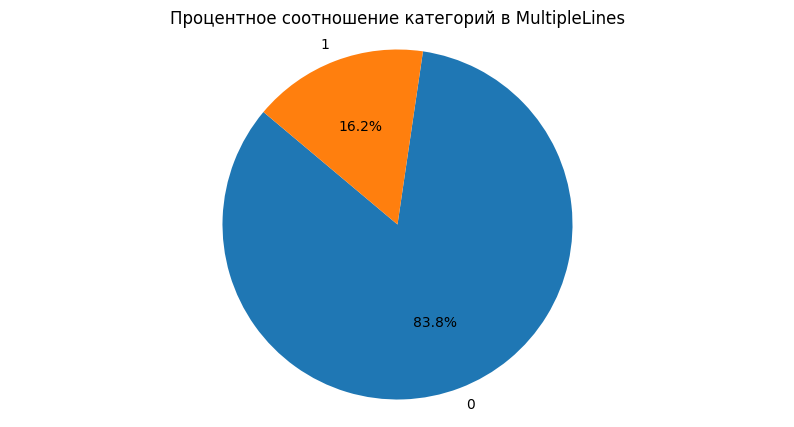

In [21]:
make_pie(all_data, 'SeniorCitizen')

В датасете 16.2% пенсионеров. Также посмотрим на распределение этого признака в разрезе типа услуг: телефонии и интернета:

In [22]:
all_data_phone = all_data[all_data.index.isin(phone_new['customerID'])]
all_data_internet = all_data[all_data.index.isin(internet_new['customerID'])]

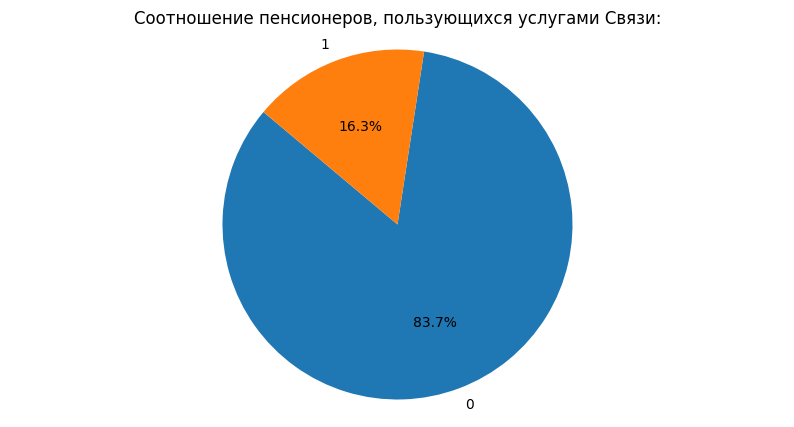

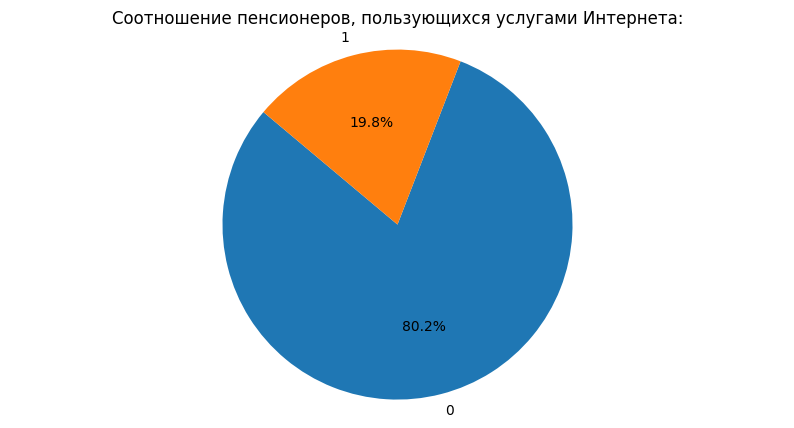

In [23]:
make_pie(all_data_phone, 'SeniorCitizen', show_title=True, title='Соотношение пенсионеров, пользующихся услугами Связи:')

make_pie(all_data_internet, 'SeniorCitizen', show_title=True, title='Соотношение пенсионеров, пользующихся услугами Интернета:')

**Результат:**  

Общее соотношение пенсионеров в датасете - 16.2%. При этом пенсионеров пользующихся услугами интернета в прцоентном соотношении немного больше, чем пользующихся услугами связи - ~20% против ~16%.

Дальше рассмотрим признак **Наличия Партнера**:

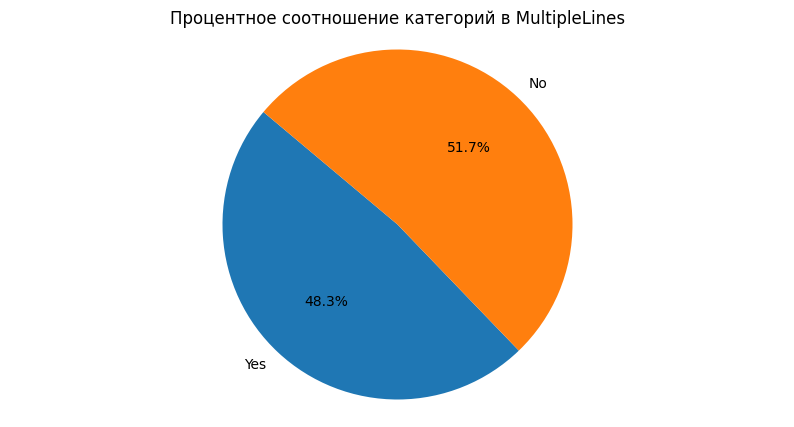

In [24]:
make_pie(all_data, 'Partner')

Ситуация такая же, как и с полом - количество людей с парой такое же, как и людей без пары. Посмотрим также на этот признак с учетом типа предоставляемых услуг:

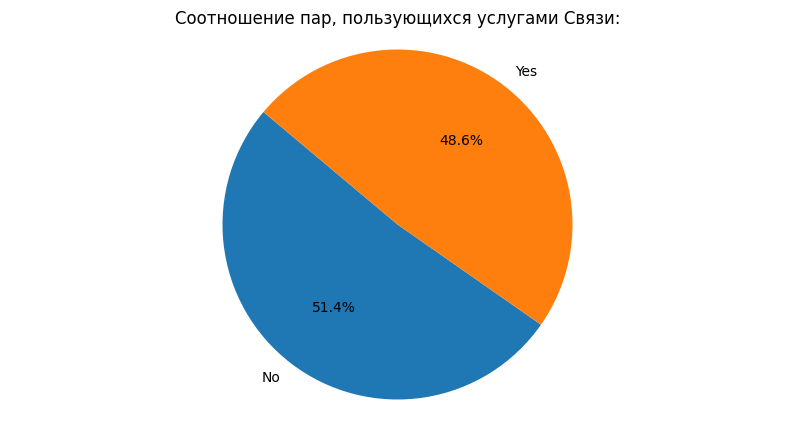

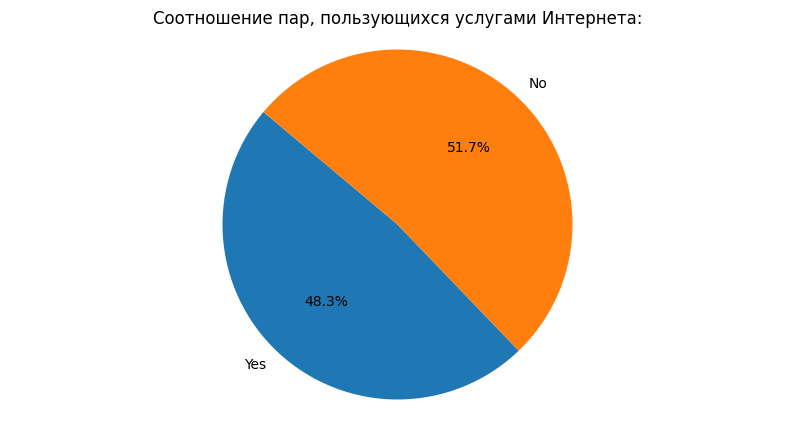

In [25]:
make_pie(all_data_phone, 'Partner', show_title=True, title='Соотношение пар, пользующихся услугами Связи:')


make_pie(all_data_internet, 'Partner', show_title=True, title='Соотношение пар, пользующихся услугами Интернета:')

**Результат:**

Признак **Наличия Партнера** распределен в равной степени. При чем, тип предоставляемой услуги не важен: люди с парой и без пользуются интернетом и телефонией в равной степени.

Исследуем далее признак **Dependents** с распределением клиентов с детьми:

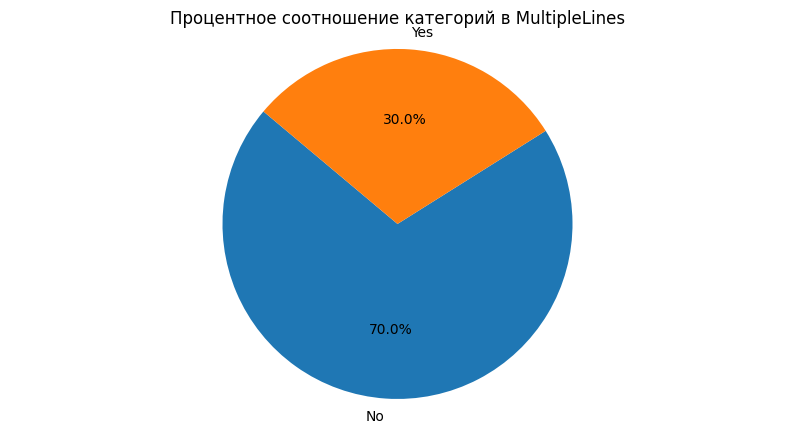

In [26]:
make_pie(all_data, 'Dependents')

У 30% клиентов есть дети. Посмотрим, сказывается ли это как-то на сумме месячного платежа, может семьи пользуются более дешевыми или дорогими тарифами:

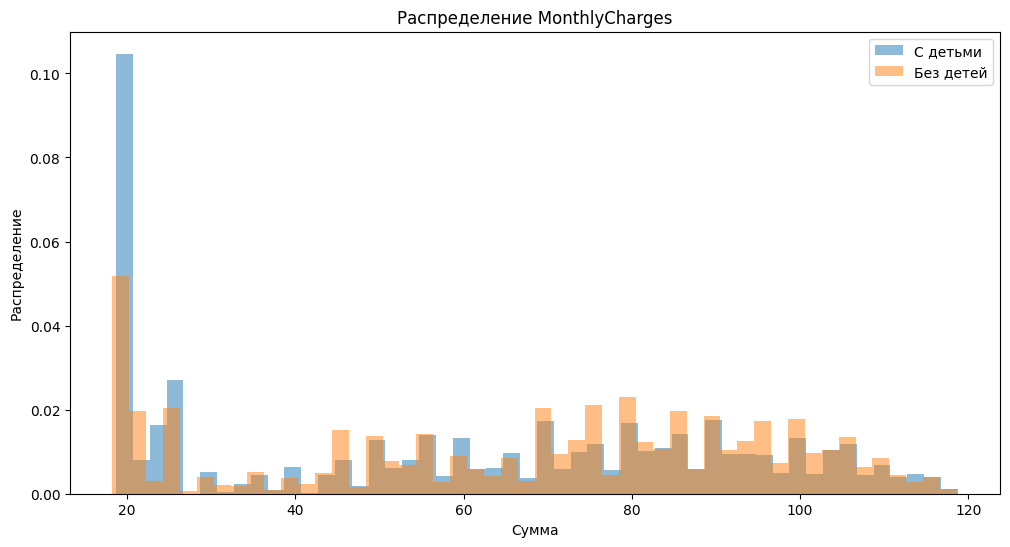

In [27]:
plt.figure(figsize=(12, 6))
make_hist(data=all_data, column="MonthlyCharges", xlabel="Сумма", ylabel="Распределение", num_bins=50, condition="Yes", condition_column="Dependents", condition_label="С детьми")
make_hist(data=all_data, column="MonthlyCharges", xlabel="Сумма", ylabel="Распределение", num_bins=50, condition="No", condition_column="Dependents", condition_label="Без детей")
plt.legend()
plt.show()

**Результат:**
 
  Всего в данных 30% пользователей с детьми. Семьи c детьми чаще берут тарифы дешевле. Возможно кампания предоставляет спецальные пакеты.

Теперь исследуем **дату начала действия договора**.

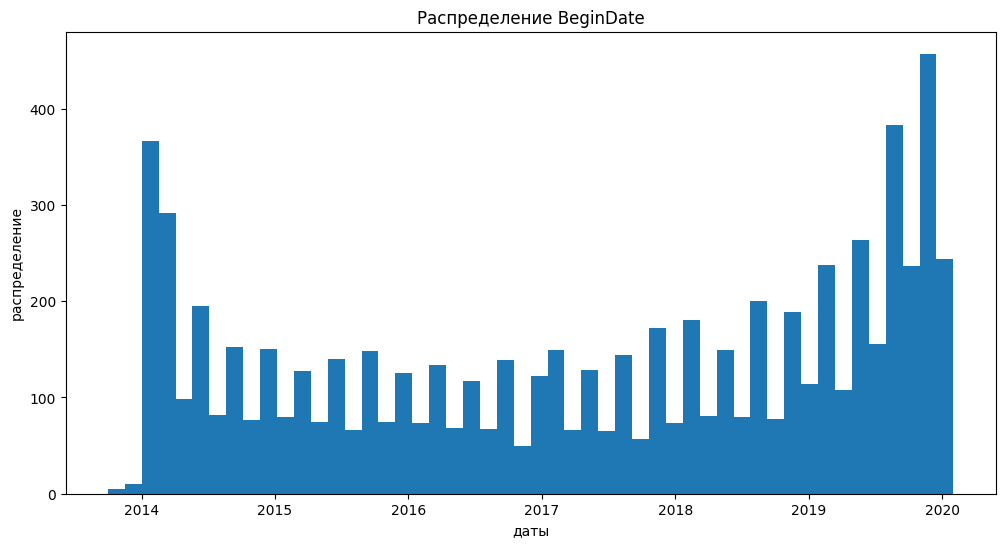

In [28]:
plt.figure(figsize=(12, 6))
make_hist(all_data, 'BeginDate', 'даты', 'распределение')

Судя по распределению данного признака, можно сказать, что компания пользовалась большим спросом в 2014 году, достигнув ~350 регистраций новых контрактов. После чего 5 лет держалась примерно одинаковая популярнось. В 2020 году количество новых регистраций резко пошло вверх. Также на графике видна переодическое появление большого числа регистраций, вероятно это сезонные пиар кампании.

Рассмотрим данных признак в разрезе ежемесячных платежей. 

Выберем нужные столбцы в одну таблицу и посмотрим на взаимосвязи в данных. Возьмем период данных с 2017 до 2019 т.к. в таком масштабе будет хорошо видно взаимосвязи. А также данный диаппазон времени является актуальным.

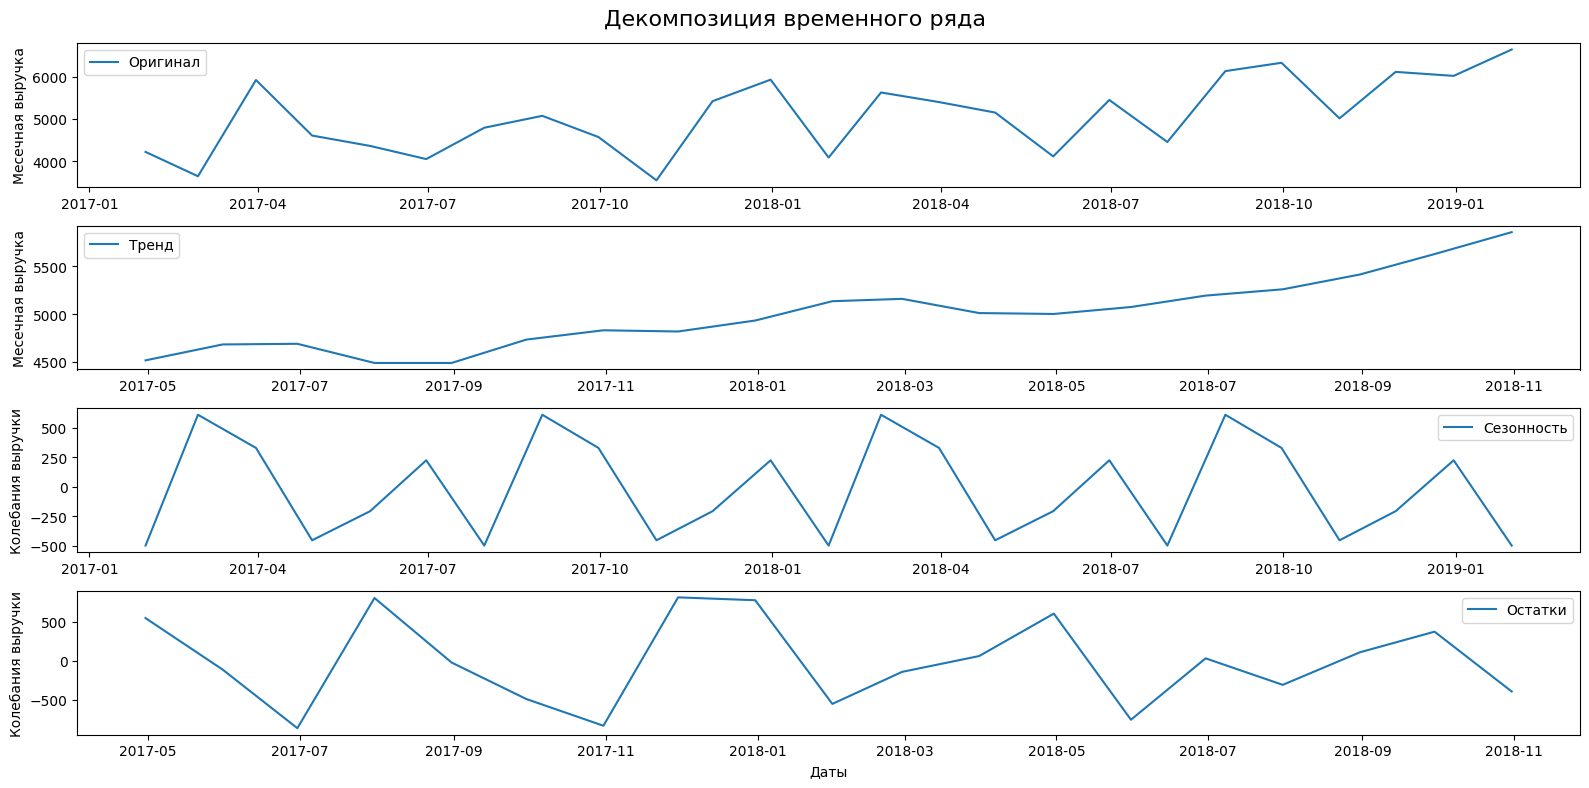

In [29]:
all_data_dates = all_data[['BeginDate', 'MonthlyCharges']]
all_data_dates = all_data_dates.sort_values('BeginDate')
decompose_time_series(all_data_dates, 'BeginDate', 'MonthlyCharges', model='additive', period=6, start_date='2017-01', end_date='2019-01', ylabel_1='Месечная выручка', ylabel_2='Месечная выручка', ylabel_3='Колебания выручки', ylabel_4='Колебания выручки', x_label='Даты' )

**Результат:**  
  
  Компания пользовалась большим спросом в 2014 году, достигнув ~350 регистраций новых контрактов. После чего 5 лет держалась примерно одинаковая популярнось. В 2020 году количество новых регистраций резко пошло вверх. По анализу трендовости можно сказать, что общая месечная прибыль компании растет с каждым годом. На графике сезонности явно видно, что в апреле, январе, июле и октябре обычно растут общие месячные выплаты. Это скорее всего связано с привлечением новых людей, то есть с проведением рекламных кампаний в эти даты.

Теперь проанализируем признак **EndDate**. 
Построим гистограмму с ее распределением, а также посчитаем среднее время, спустя которое люди отписываются. Будем учитывать данные без 2020 года т.к. значения за 1 февраля 2020 года учитываются, как пользователи не отменившие свои подписки.

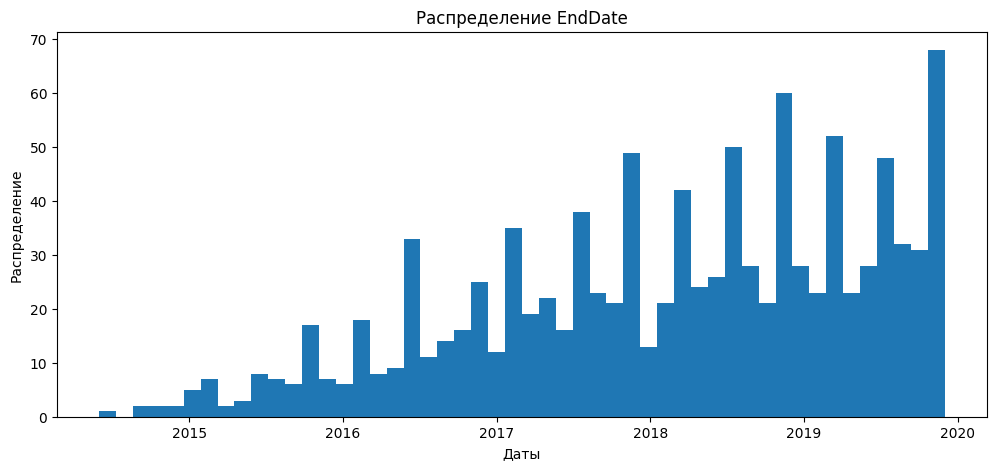

In [30]:
plt.figure(figsize=(12, 5))
make_hist(all_data[all_data['EndDate'].dt.year < 2020], 'EndDate', 'Даты', 'Распределение')

С каждым годом количество отписавшихся людей растет. Добавим новый признак кол-ва дней с начала подписки и до конца, а также посчитаем сколько в среднем на это уходит времени.

In [31]:
all_data['duration'] = (all_data['EndDate'] - all_data['BeginDate']).dt.days
duration = all_data['duration'].dropna()
average_duration = duration.mean()
print(f'Среднее кол-во дней: {average_duration}')

Среднее кол-во дней: 898.5557290927162


В среднем у людей уходит около 2.5 лет перед тем, как они отменят подписку

**Результат:**

  С каждым годом количество отписавшихся людей растет. В среднем у людей уходит около 2.5 лет перед тем, как они отменят подписку

Дальше проверим распределение типа олаты **Type**:

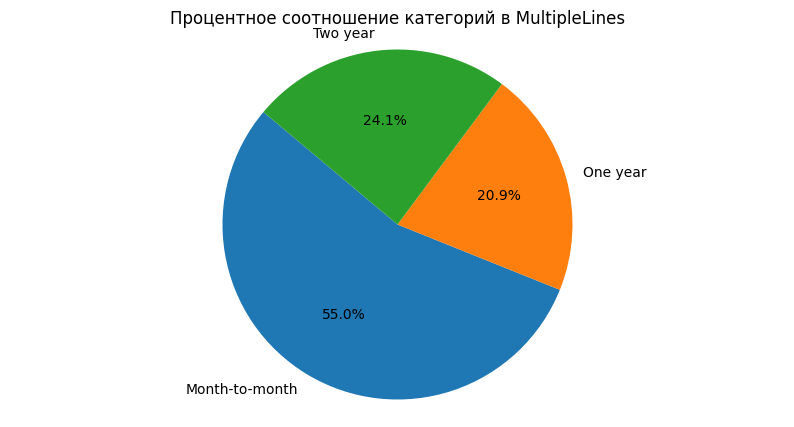

In [32]:
make_pie(all_data, 'Type')

**Результат:**

  Чуть больше чем у половины всех клиентов подписка оплачивается ежемесячно. Годовая и двухгодовая оплаты распределены примерно в равной степени. Двухгодовая оплата немного популярнее. Это скорее всего связано с выгодной ценой.

Теперь проверим признак **PaperlessBilling**, который показывает наличие электронного платежного документа:

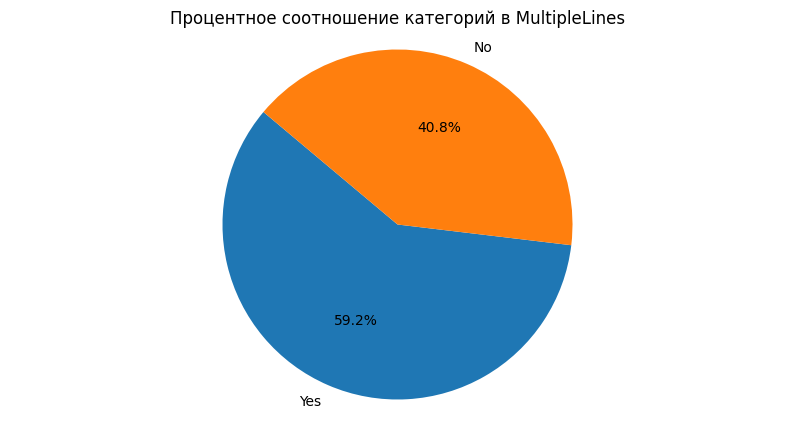

In [33]:
make_pie(all_data, 'PaperlessBilling')

**Результат:**

  Пользователей, использующих электронный платежный документ почти на 20% меньше.

Посмотрим на распределение **метода оплаты** среди клиентов:

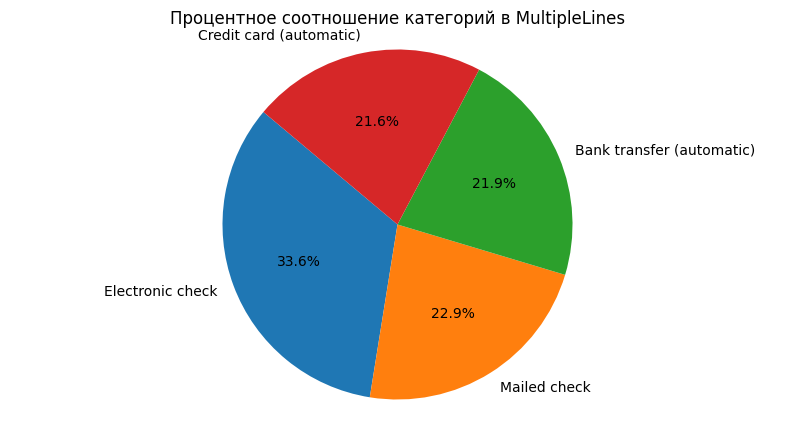

In [34]:
make_pie(all_data, 'PaymentMethod')

**Результат:**

  21.6% людей использует кредитную карту для оплаты, 21.9% использует банковский платёж, 22.9 использует физический чек. Самым популярным типом оплаты оказался электронный чек с 33.6%

Посмотрим на распределение **месячных расходов клиентов**:

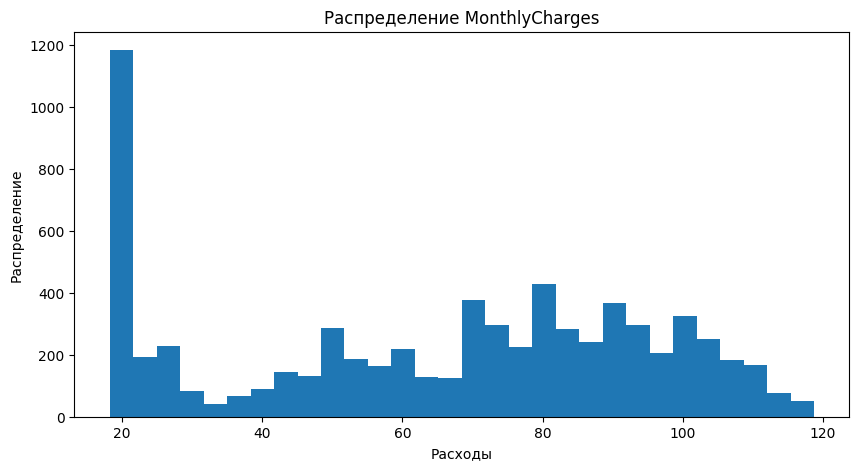

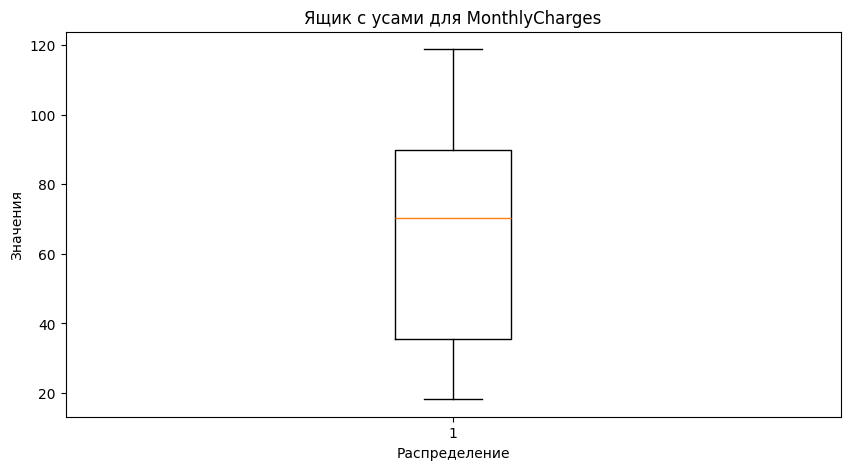

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64


In [35]:
plt.figure(figsize=(10, 5))
make_hist(all_data, 'MonthlyCharges', 'Расходы', 'Распределение', num_bins=30)
plt.show()

make_boxplot(all_data, 'MonthlyCharges')

**Результат:**

  Распределение месячных расходов клиентов имеет пик в значении около 20. Как было выяснено раньше, это вероятно связано с наличием специальных услуг для семей с детьми с меньшими ценами на тарифы. Среднее сумма затрат - 64, а медиана распологается в значении 70.

Теперь глянем на гистограмму распределения признака **общих расходов клиентов:**

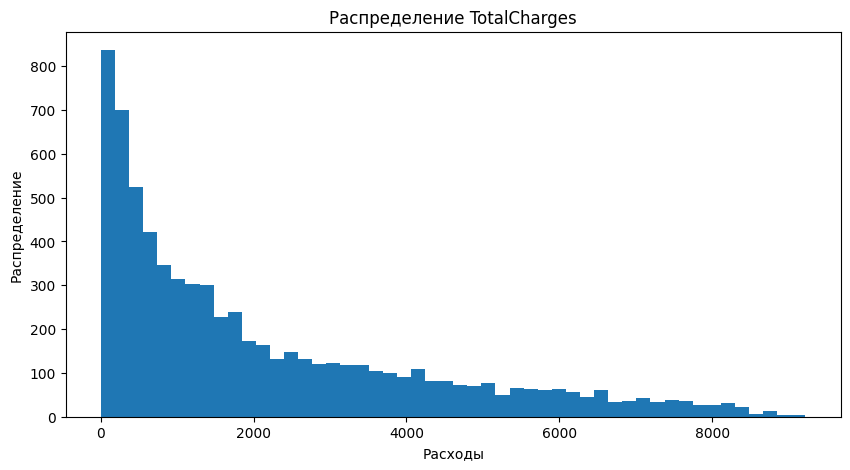

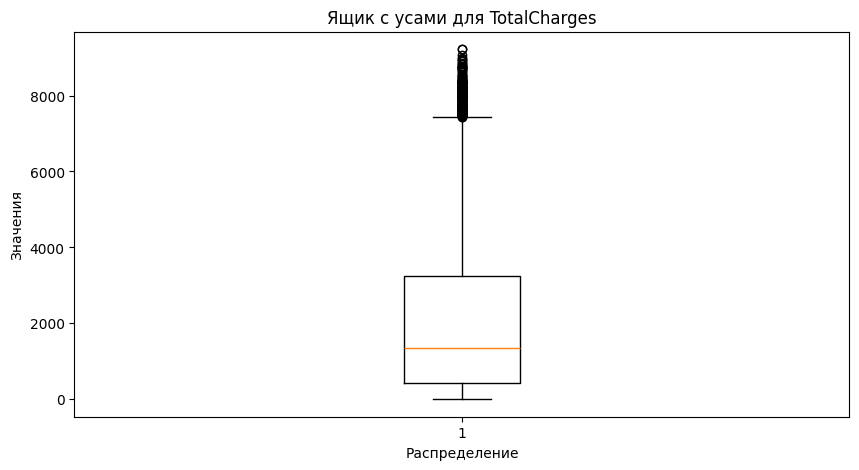

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64


In [36]:
plt.figure(figsize=(10, 5))
make_hist(all_data, 'TotalCharges', 'Расходы', 'Распределение')
plt.show()

make_boxplot(all_data.dropna(), 'TotalCharges')

**Результат:**

  На гистограмме наблюдается нисходящий график со средним значением оплаты в 2803 и медианой в 2711. Очень хорошо виден пик в левой части графика - это говорит о том, что людей, потративших меньше денег на тарифы больше.

Следующий признак - **InternetService**. В нем содержится тип подключения.

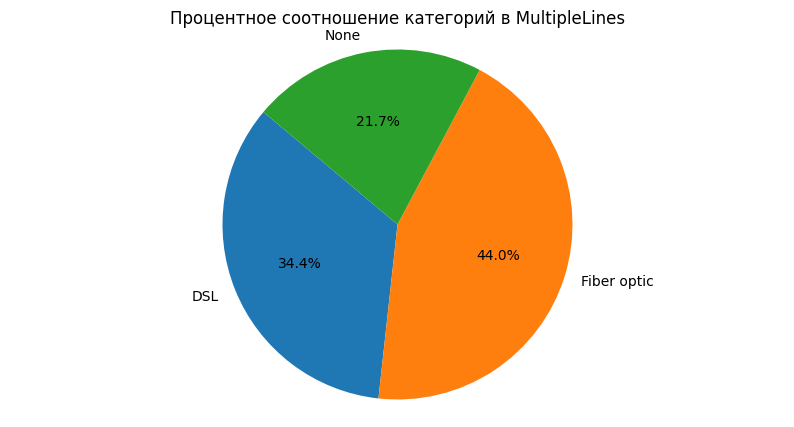

In [37]:
make_pie(all_data, 'InternetService')

**Результат:**

  В распределении признака InternetService 34.4% клиентов имеют подключение DSL, 44% клиентов имеют подключение Fiberic optic и 21.7% не пользуются данной услугой.

Теперь исследуем распределение признака **OnlineSecurity**. Узнаем процентное соотношению людей с данной услугой:

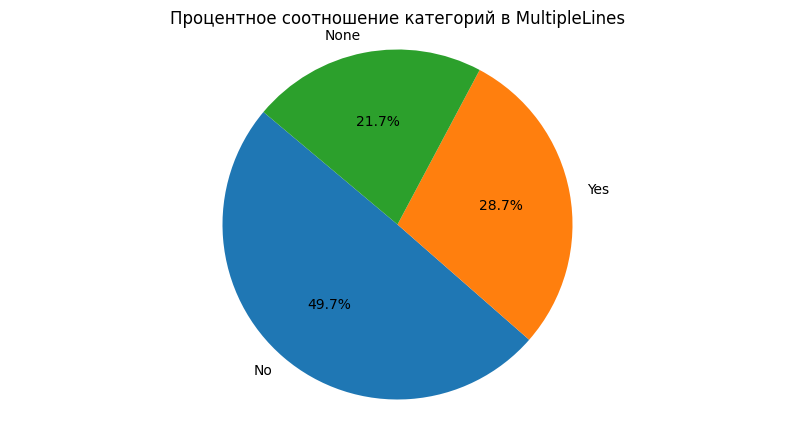

In [38]:
make_pie(all_data, 'OnlineSecurity')

**Результат:**
  
  49.7% людей не имеют услуги онлайн безопасности, 28.7% пользуются. У 21.7% данной услуги нету

Теперь посмотрим на признак **OnlineBackup**:

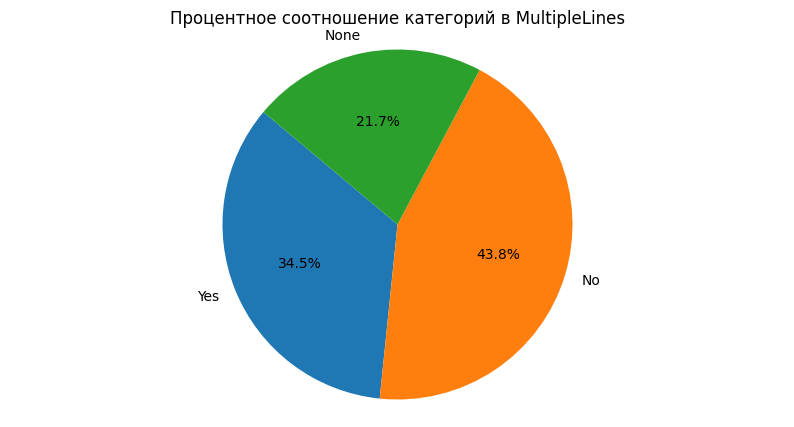

In [39]:
make_pie(all_data, 'OnlineBackup')

**Результат:**

  43.8% всех пользователей не имеют услуги облачного хранилища файлов для резервного копирования данных. Этим пользуются только 34.5%. У 21.7% данной услуги нету

Следующая услуга, которую могли подключить себе клиенты - **DeviceProtection**.

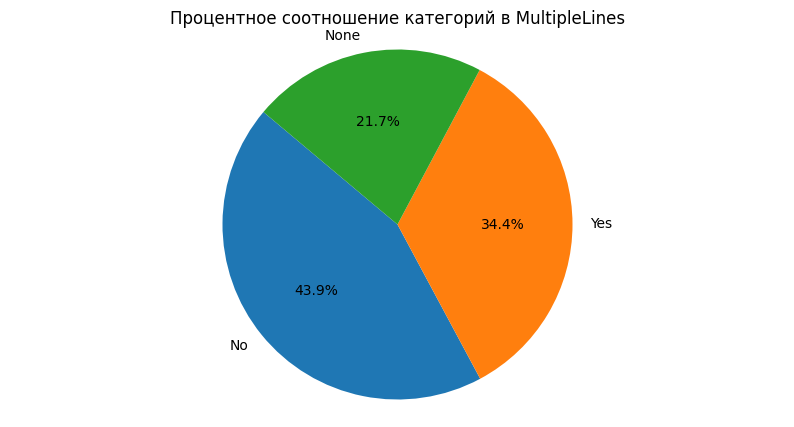

In [40]:
make_pie(all_data, 'DeviceProtection')

**Результат:**

  У 43.9% пользователей нет услуги антивируса. У 34.4% она есть. У 21.7% услуги интернета нету.

Теперь взглянем на следеющую услугу - **техническую поддержу ``TechSupport``**:

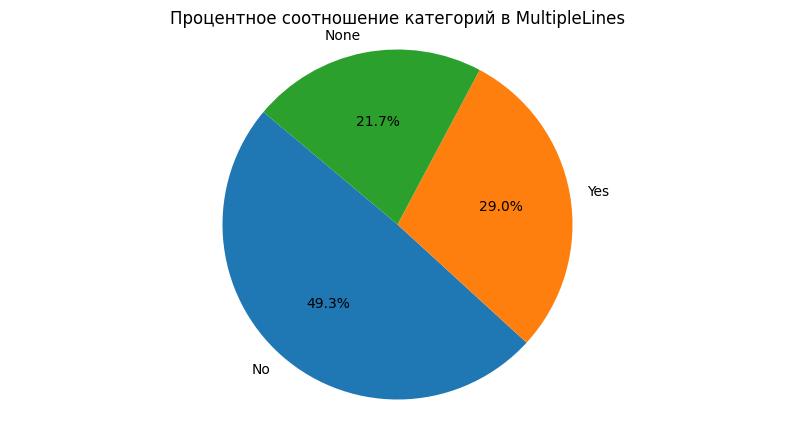

In [41]:
make_pie(all_data, 'TechSupport')

**Результат:**

  49.3% клиентов не имеют выделенной линии технической поддержки. 29% пользуются данной услугой.

Еще один признак, указывающий на наличие услуги - **StreamingTV**:

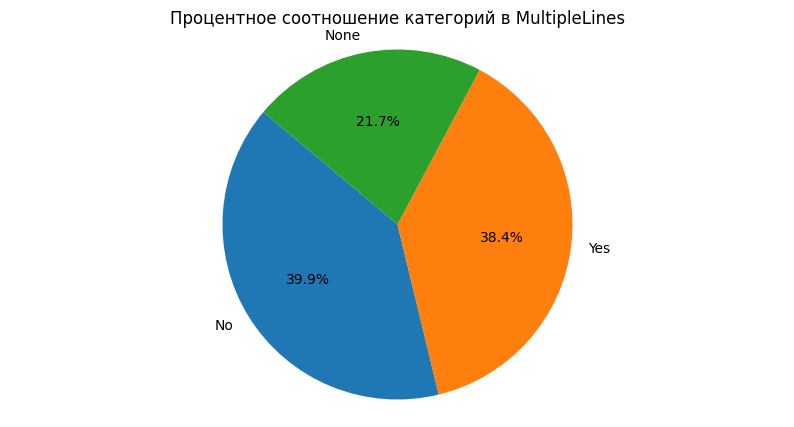

In [42]:
make_pie(all_data, 'StreamingTV')

**Результат:**

  У 39.9% клиентов данной услуги нет. У 38.4% эта услуга есть.

Следующий категориальный признак - **StreamingMovies**

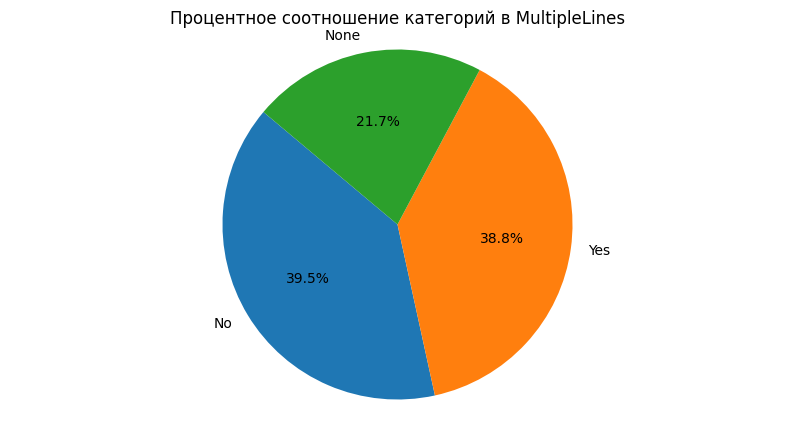

In [43]:
make_pie(all_data, 'StreamingMovies')

**Результат:**

  У 39.5% пользователей не подключена услуга стримингово телевидения. Им пользуются 38.8% пользователей. А у 21.7% данная услуги нету.

Последний категориальный, ключевой признак - признак отписки **is_canceled**. Посмотрим на его распределение:

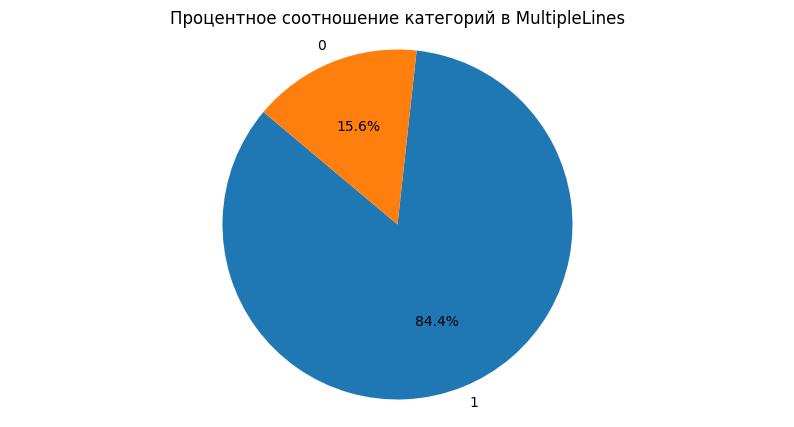

In [44]:
make_pie(all_data, 'is_canceled')

**Результат:**

  15.6% пользователей отписались от предоставленных компанией услуг. Взглянем на распределение этого признака с учетом типа услуг:

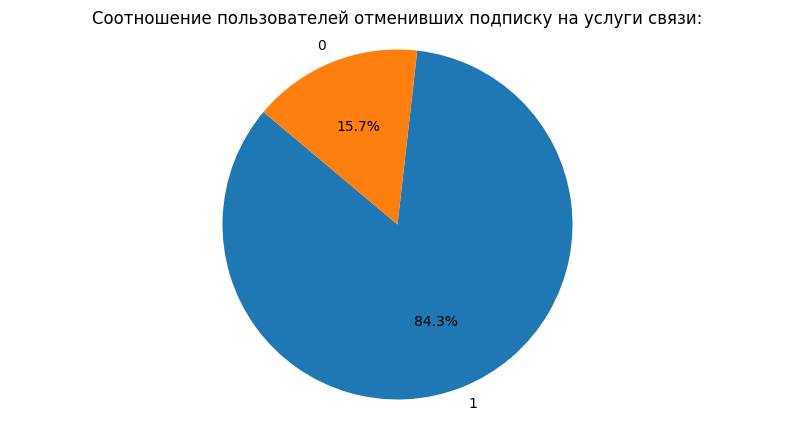

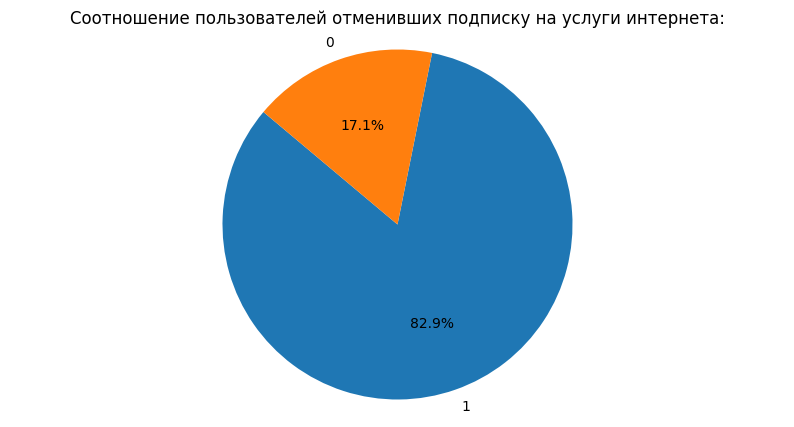

In [45]:
make_pie(all_data_phone, 'is_canceled', show_title=True, title='Соотношение пользователей отменивших подписку на услуги связи:')


make_pie(all_data_internet, 'is_canceled', show_title=True, title='Соотношение пользователей отменивших подписку на услуги интернета:')

**Результат:**

  Пользователей, отменивших свои подписки всего в датасете - 15.6%. Из них, пользовавшихся услугами связи отменило подписку 15.7%, а пользовавшихся услугами интернета - 17.1%. При проектировании модели мы будем использовать метрику оценки AUC-ROC, которая не чувствительна к дисбалансу классов. Поэтому оставим данные как есть.

**Промежуточные выводы по каждому из признаков:**
- ``Пол клиентов``: Распределение равное, что не указывает на какую-либо сильную взаимосвязь или ошибку в данных.

- ``SeniorCitizen``: 16.2% клиентов - пенсионеры. При этом, среди пользователей интернет-услуг пенсионеров больше (20%) по сравнению с пользователями телефонии (16%).

- ``Наличие Партнера``: Равное распределение между клиентами с партнером и без. Тип предоставляемых услуг (телефония или интернет) на это не влияет.

- ``Dependents (наличие детей)``: У 30% клиентов есть дети. Эти семьи склонны выбирать более дешевые тарифы.

- ``Дата начала действия договора (BeginDate)``: Заметный спрос на услуги компании в 2014 году и в 2020. Регистрации новых контрактов часто увеличиваются в определенные периоды, возможно, благодаря сезонным маркетинговым акциям. Рост ежемесячной прибыли компании за последние годы.

- ``Дата окончания договора (EndDate)``: Увеличение количества отписавшихся клиентов с каждым годом. Средний срок использования услуг до отмены подписки составляет около 2.5 лет.

- ``Тип оплаты (Type)``: Ежемесячная оплата наиболее популярна, за ней следуют годовая и двухгодовая оплаты, с небольшим преимуществом последней.

- ``PaperlessBilling``: Почти 20% меньше пользователей, использующих электронные платежные документы, чем тех, кто их не использует.

- ``Метод оплаты (PaymentMethod)``: Электронный чек является самым популярным способом оплаты, за ним следуют кредитная карта, банковский перевод и физический чек.

- ``Месячные расходы (MonthlyCharges)``: Наибольшее количество клиентов тратит около 20. Среднее значение расходов около 64, а медиана - 70.

- ``Общие расходы (TotalCharges)``: Среднее значение 2803, медиана 2711. Высокий пик на меньших значениях расходов.

- ``InternetService``: 44% клиентов используют оптическое волокно, 34.4% - DSL, и 21.7% не пользуются интернетом.

- ``OnlineSecurity``: 71.3% клиентов не имеют данной услуги, остальные - пользуются.

- ``OnlineBackup`: 65.5% клиентов не используют услугу, 34.5% - используют.

- ``DeviceProtection``: У 65.6% клиентов нет этой услуги, у остальных - есть.

- ``TechSupport``: 71% клиентов не имеют выделенной технической поддержки.

- ``StreamingTV``: У 61.5% нет этой услуги, у 38.4% - есть.

- ``StreamingMovies``: У 61.2% нет услуги стримингового телевидения, у 38.8% - есть.

- ``is_canceled``: 15.6% клиентов отменили подписку. Среди пользователей услуг связи и интернета примерно равное количество отмен, с небольшим превышением среди пользователей интернет-услуг (17.1% против 15.7%). Так как при проектировании модели мы будем использовать метрику оценки AUC-ROC, оставим данные как есть, ведь она не чувствительна к дисбалансу классов.

### Исследование корреляций
<a id='8'></a>

Проведем исследование корреляций между признаками. Для этого построим матрицу корреляций Phik, с расчетом Phi_k корреляции. Данная корреляция подходит для работы с категориальными и смешанными типами данных. С ее помощью можно эффективно оценить корреляции между любыми типами переменных.

Так как признаки начала и конца подписки нам больше не понадобятся, удалим их:

In [46]:
all_data.drop(['BeginDate', 'EndDate'], axis=1, inplace=True)

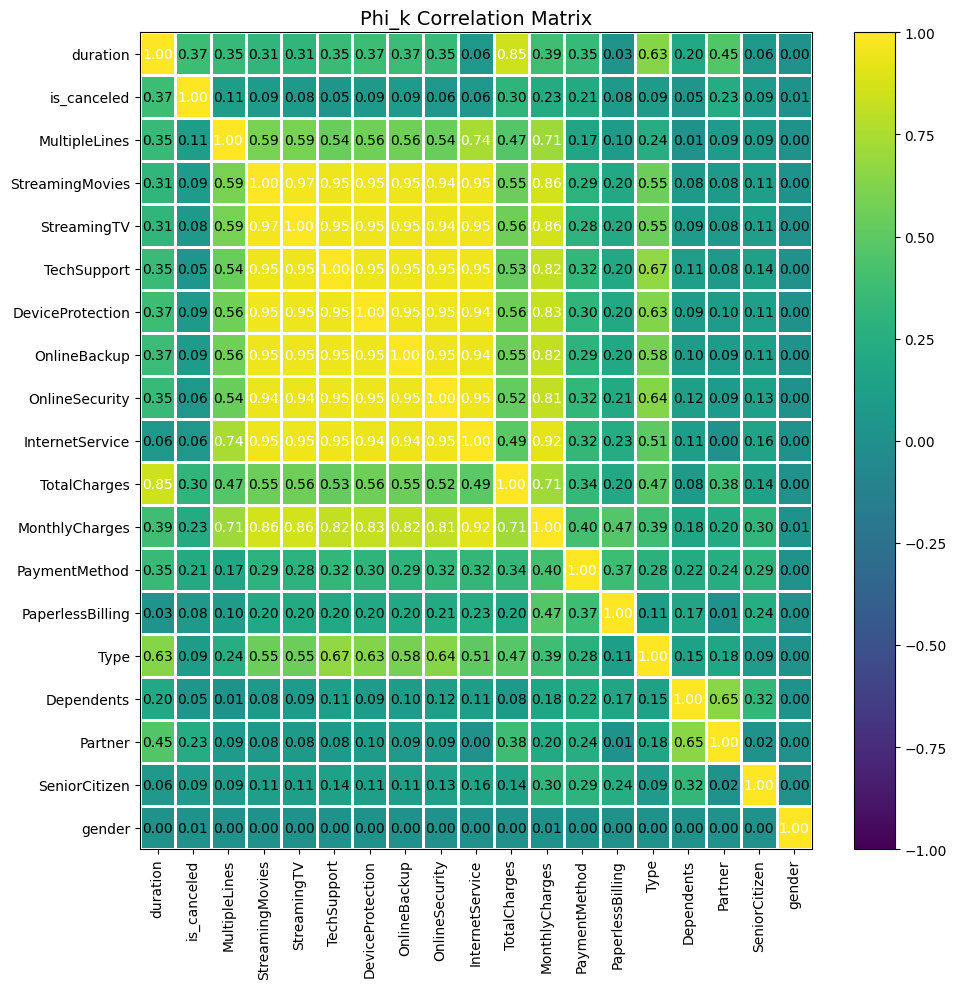

In [47]:
interval_cols = all_data.select_dtypes(include=['int', 'float']).columns #обозначение количественных признаков
phik_matrix = all_data.phik_matrix(interval_cols=interval_cols)

# Построение тепловой карты матрицы корреляций
plot_correlation_matrix(phik_matrix.values, 
                        x_labels=phik_matrix.columns, 
                        y_labels=phik_matrix.index, 
                        figsize=(10, 10), 
                        color_map='viridis', 
                        title='Phi_k Correlation Matrix')
plt.show()

**Промежуточный результат:**
  
    Судя по матрице корреляций, можно заметить, что на ключевой признак в большей степени влияют длительность времени в течении которого человек подписан на услугу и общие затраты клиента. На графике также можно увидеть несколько признаков, которые достаточно сильно коррелируют друг с другом - на графике они изображены большим желтым прямоугольником. Дело в том, что данные признаки относятся к одной основной услуге компании - интернету. И значение ``None`` в них стоит в одинаковых записях т.к. это клиенты у которых не подключен интернет. Так что удалять эти признаки не стоит, они отражают существующую зависимость в данных.

### Разделение данных на выборки, кодирование и масштабирование признаков.
<a id='9'></a>

Теперь, когда датасет готов и обработан, создадим две выборки - тренировочную и тестовую в соотношении 3:1.

In [48]:
RANDOM_STATE = 180324
target_column = 'is_canceled'
X = all_data.drop(target_column, axis=1)
y = all_data[target_column]

cat_columns = X.select_dtypes(include=['object']).columns
num_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Разделение данных в соотношении 3:1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

Закодируем категориальные признаки с помощью кодировщика OrdinalEncoder:

In [49]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [50]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

X_train_encoded[cat_columns] = encoder.fit_transform(X_train[cat_columns])
X_test_encoded[cat_columns] = encoder.transform(X_test[cat_columns])

Теперь масштабируем количественные признаки, будем использовать MinMaxScaler(), чтобы перевести все значения в диаппазон от 0 до 1:

In [51]:
scaler = MinMaxScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

X_train_scaled[num_columns] = scaler.fit_transform(X_train_encoded[num_columns])
X_test_scaled[num_columns] = scaler.transform(X_test_encoded[num_columns])

Объединим получившиеся закодированные данные:

In [52]:
X_train_preprocessed = pd.concat([pd.DataFrame(X_train_scaled, columns=num_columns), 
                                  X_train_encoded[cat_columns]], axis=1)

X_test_preprocessed = pd.concat([pd.DataFrame(X_test_scaled, columns=num_columns), 
                                 X_test_encoded[cat_columns]], axis=1)

Проверим объединенные датасеты:

In [53]:
display(X_train_preprocessed)
display(X_test_preprocessed)

,MonthlyCharges,TotalCharges,duration,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,
7493-GVFIO,0.019960,0.028971,0.171564,1.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8898-KASCD,0.169661,0.153821,0.499568,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0
7067-KSAZT,0.875250,0.821298,0.868626,0.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0
7503-MIOGA,0.711577,0.736621,0.946845,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
9851-KIELU,0.913673,0.131336,0.145635,1.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018-HEKFO,0.059381,0.026569,0.132239,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
3612-YVGSJ,0.058882,0.192018,0.934745,0.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
6108-OQZDQ,0.792415,0.063732,0.079516,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0


,MonthlyCharges,TotalCharges,duration,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,
6630-UJZMY,0.645709,0.039723,0.053155,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
9074-KGVOX,0.208583,0.147851,0.420916,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0
4537-CIBHB,0.016966,0.020160,0.119274,0.0,0.0,1.0,1.0,1.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9286-BHDQG,0.266467,0.363909,0.946845,1.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0
3292-PBZEJ,0.926647,0.132887,0.145635,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316-ESMLS,0.145709,0.044864,0.157736,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0
7993-NQLJE,0.564371,0.129491,0.197494,1.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
8010-EZLOU,0.615269,0.156549,0.237252,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0


Данные обработаны! Можно приступать к созданию моделей

***Промежуточный вывод по 2 разделу:***  
  
    Анализ распределения признаков показал значительные особенности в датасете. Ключевые факторы, влияющие на удержание клиентов, включают длительность подписки, общие расходы, а также наличие дополнительных услуг, как интернет-услуги и услуги безопасности. Особенно примечательно, что семьи с детьми склонны выбирать более дешевые тарифы. Кроме того, многие признаки, связанные с интернет-услугами, сильно коррелируют между собой. Категориальные данные были закодированы с помощью кодировщика OrdinalEncoder(то есть каждой категории была присвоена своя цифра), а количественные данные были закодированы с помощью MinMaxScaler скейлера и переведены в масштаб от 0 до 1.

## Обучение моделей МО
<a id='10'></a>

Данный раздел будет состоять из двух этапов:
- Обучение двух моделей с подбором гиперпараметров: случайный лес (Random Forest) и градиентный бустинг (XGBoost)
- Выбор лучшей модели и тестирование ее на тестовых данных
- Интерпретация весов
- Интерпретация матрицы ошибок

### Обучение трех моделей МО
<a id='11'></a>

Обучим три модели с разными алгоритмами решения: случайный лес (Random Forest), градиентный бустинг XGBoost и градиентный бустинг CatBoost . Для всех подберем гиперпараметры. Для поиска решения будем использовать кросс валидацию.

Начнем со случайного леса:

In [54]:
rf_params = {
    'n_estimators': [500, 600, 700],
    'max_depth': [None] + [i for i in range(2, 7)],
    'min_samples_split': [5, 10]
}

In [55]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

In [56]:
# Используем 'roc_auc' в качестве значения для scoring
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train_preprocessed, y_train)

print("Лучшие параметры для RandomForest:", rf_grid.best_params_)
print("Лучший AUC-ROC для RandomForest:", rf_grid.best_score_)

Лучшие параметры для RandomForest: {'max_depth': 6, 'min_samples_split': 10, 'n_estimators': 600}
Лучший AUC-ROC для RandomForest: 0.8326671790698977


Результат достаточно неплохой. Обучим теперь модель градиентного бустинга:

In [57]:
xgb_params = {
    'n_estimators': [200, 300],
    'max_depth': [2, 3],
    'learning_rate': [0.2]
}

xg_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)

# Создаем GridSearchCV с кросс-валидацией
xgb_grid = GridSearchCV(xg_clf, xgb_params, cv=2, verbose=3, scoring=make_scorer(roc_auc_score))
xgb_grid.fit(X_train_preprocessed, y_train)

# Лучшие параметры и результат
print("Лучшие параметры для XGBoost:", xgb_grid.best_params_)
print("Лучший AUC-ROC для XGBoost:", xgb_grid.best_score_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=0.665 total time=   0.2s
[CV 2/2] END learning_rate=0.2, max_depth=2, n_estimators=200;, score=0.644 total time=   0.1s
[CV 1/2] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.678 total time=   0.3s
[CV 2/2] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.671 total time=   0.3s
[CV 1/2] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.691 total time=   0.2s
[CV 2/2] END learning_rate=0.2, max_depth=3, n_estimators=200;, score=0.666 total time=   0.2s
[CV 1/2] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.710 total time=   0.4s
[CV 2/2] END learning_rate=0.2, max_depth=3, n_estimators=300;, score=0.680 total time=   0.3s
Лучшие параметры для XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Лучший AUC-ROC для XGBoost: 0.6951064148681055


Результат намного хуже. Попробуем еще одну модель - Градиентный бустинг, используя CatBoost:

In [58]:
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 300]
}

cb = CatBoostClassifier(verbose=3, eval_metric='AUC', random_state=RANDOM_STATE)

In [59]:
grid_search = GridSearchCV(cb, param_grid, cv=3, scoring=make_scorer(roc_auc_score, needs_proba=True))
grid_search.fit(X_train_preprocessed, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший AUC-ROC:", grid_search.best_score_)

0:	total: 142ms	remaining: 14.1s
3:	total: 150ms	remaining: 3.61s
6:	total: 159ms	remaining: 2.11s
9:	total: 167ms	remaining: 1.5s
12:	total: 176ms	remaining: 1.17s
15:	total: 184ms	remaining: 966ms
18:	total: 192ms	remaining: 820ms
21:	total: 201ms	remaining: 711ms
24:	total: 209ms	remaining: 627ms
27:	total: 218ms	remaining: 560ms
30:	total: 227ms	remaining: 504ms
33:	total: 236ms	remaining: 458ms
36:	total: 243ms	remaining: 414ms
39:	total: 249ms	remaining: 373ms
42:	total: 254ms	remaining: 337ms
45:	total: 259ms	remaining: 304ms
48:	total: 263ms	remaining: 274ms
51:	total: 268ms	remaining: 248ms
54:	total: 273ms	remaining: 223ms
57:	total: 278ms	remaining: 202ms
60:	total: 283ms	remaining: 181ms
63:	total: 288ms	remaining: 162ms
66:	total: 293ms	remaining: 144ms
69:	total: 299ms	remaining: 128ms
72:	total: 305ms	remaining: 113ms
75:	total: 309ms	remaining: 97.7ms
78:	total: 314ms	remaining: 83.5ms
81:	total: 319ms	remaining: 70.1ms
84:	total: 325ms	remaining: 57.3ms
87:	total: 329m

Значение метрики - 0.89! Это лучший результат которого удалось достичь, поэтому выберем данную модель и проверим ее на тестовой выборке.
Подобранные гиперпараметры у данной модели:
- depth = 4. Каждое дерево в ансамбле будет иметь максимум 4 уровня
- iterations = 300. Этот параметр означает, что в ансамбле будет построено 300 последовательных деревьев, где каждое следующее дерево стремится исправить ошибки предыдущего.
- learning_rate = 0.2. Данный параметр определеяет скорость обучения. 0.2 оказалось самым подходящим значением - дерево и не пропустило минимум, и дошло до него быстро.

Запишем лучшую модель в переменную:

In [60]:
best_model = grid_search.best_estimator_

### Проверка выбранной модели на тестовых данных
<a id='12'></a>

Проверим выбранную модель(CatBoost) на тестовых данных. Посчитаем две метрики: auc-roc и accuracy т.к. accuracy проще интерпретировать

In [61]:
y_pred_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]
y_preds = best_model.predict(X_test_preprocessed)

print(f'Метрика AUC-ROC на тестовой выборке: {roc_auc_score(y_test, y_pred_proba)}')
print(f'Метрика Accuracy на тестовой выборке: {accuracy_score(y_test, y_preds)}')

Метрика AUC-ROC на тестовой выборке: 0.9223623582971084
Метрика Accuracy на тестовой выборке: 0.935831913685406


Значение метрик весьма высокое. В 93% случаев модель правильно угадывает уходящих клиентов.

### Анализ и интерпретация важности признаков
<a id='13'></a>

Посмотрим на сводную диаграмму важности признаков в модели:

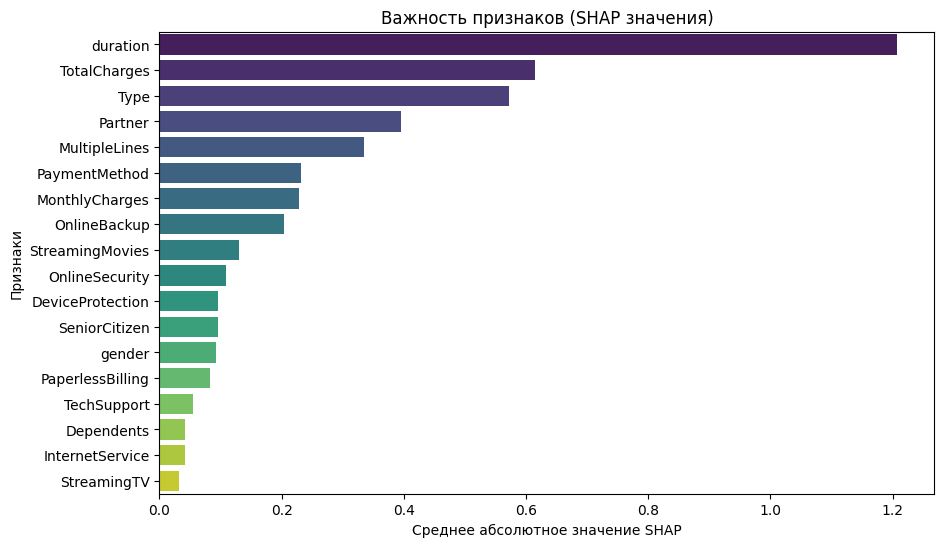

In [62]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train_preprocessed)

shap_df = pd.DataFrame(shap_values.values, columns=X_train_preprocessed.columns)

# Суммирование абсолютных значений SHAP для каждого признака
shap_sum = shap_df.abs().mean().sort_values(ascending=False)

# Создание DataFrame для визуализации
shap_sum_df = pd.DataFrame({'feature': shap_sum.index, 'shap_importance': shap_sum.values})

# Построение графика
plt.figure(figsize=(10, 6))
sns.barplot(x='shap_importance', y='feature', data=shap_sum_df, palette='viridis')
plt.xlabel('Среднее абсолютное значение SHAP')
plt.ylabel('Признаки')
plt.title('Важность признаков (SHAP значения)')
plt.show()

***На этом графике можно заметить следующие наблюдения:***

   Самым важным признаком влияющим на предсказание является длительность контракта клиента. Это означает, что продолжительность использования услуг клиентом является наиболее значимым фактором при принятии моделью решений о классификации клиентов как уходящих или оставшихся.

   После длительности контракта идут такие признаки как общие траты и тип оплаты. Понятно, что признак общих затрат отвечает за финансовую состовляющую клиента и вероятно, при оформлении подписки с помесячной оплатой, клиенты ее "пробуют" в первый раз. Соответственно, велик шанс что они уйдут оставив небольшое кол-во денег. Пользователи, оформляющие подписку с годовой или двухгодовой оплатой делают это с мыслью, что этой услугой они точно будут пользоваться на постоянной основе и соответсвенно денег оставляют больше.

Также посмотрим на график SHAP beeswarm plot, который показывает распределение SHAP значений для каждого признака. Это нужно для понимания как именно признаки влияют на предсказание:

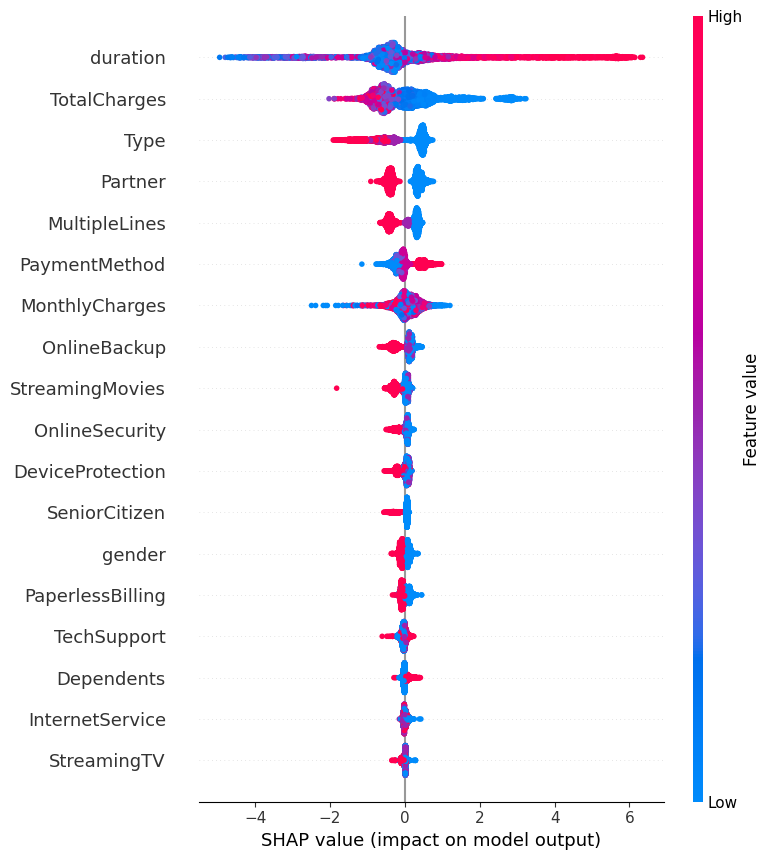

In [63]:
shap.summary_plot(shap_values, X_train_preprocessed)

Из этого графика можно выделить следующее:
- Чем дольше длится контракт, тем вероятнее что клиент отпишется от услуги. Чем меньше времени - тем вероятнее, что клиент еще останется
- Чем меньше общие затраты клиента, тем вероятнее он уйдет. Это подтверждение вывода к прошлому графику. Клиенты, похоже, дейстрвительно "пробуют" подписку на услугу и отписываются.
- Так как мы использовали OrdinalEncoder при кодировании категориальных признаков и он присвоил значениям следующие зависимости: Помесячная оплата - 0, годовая - 1 и двухгодовая - 2. То это тоже подтверждение прошлой теории, что чем короче срок оплаты подписки, - тем выше шанс, что клиент уйдет.

**Промежуточный результат:**  
 
      В анализе данных по клиентам, важнейшим фактором, влияющим на предсказание их ухода или остатка, является длительность контракта. Клиенты с более долгими контрактами склонны реже отказываться от услуг, в то время как клиенты с короткими контрактами чаще уходят, возможно, из-за "пробного" использования услуги. Другие значимые факторы включают общие траты клиента и тип оплаты: клиенты с низкими общими затратами и помесячной оплатой более склонны к отказу от подписки, в то время как те, кто выбирает годовую или двухгодовую оплату, обычно оставляют за собой более значительные финансовые вложения и, соответственно, реже отказываются от услуг.

### Интерпретация матрицы ошибок
<a id='14'></a>

Теперь посмотрим на матрицу ошибок и выясним как именно ошибается модель:

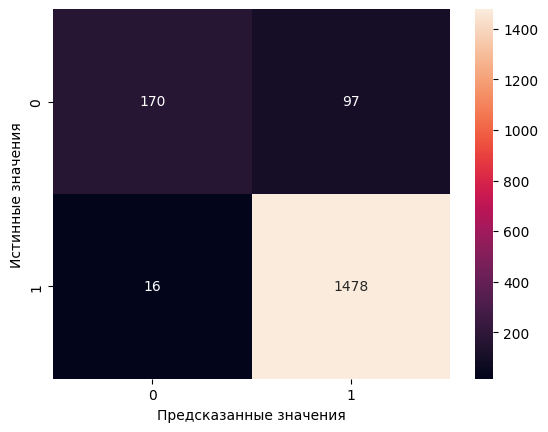

              precision    recall  f1-score   support

           0       0.91      0.64      0.75       267
           1       0.94      0.99      0.96      1494

    accuracy                           0.94      1761
   macro avg       0.93      0.81      0.86      1761
weighted avg       0.93      0.94      0.93      1761



In [64]:
cm = confusion_matrix(y_test, y_preds)

# Визуализация матрицы ошибок
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

# Расчет основных метрик
report = classification_report(y_test, y_preds)
print(report)

**Матрица ошибок:**

- Истинно отрицательные (TN): 165 предсказаний класса "0" (остающиеся клиенты) верны.
- Ложно положительные (FP): 102 случая, когда модель неправильно предсказала клиентов, которые останутся (класс "0"), как уходящих (класс "1").
- Ложно отрицательные (FN): 12 случаев, когда модель неправильно предсказала клиентов, которые уходят (класс "1"), как остающихся.
- Истинно положительные (TP): 1482 предсказания класса "1" (уходящие клиенты) верны.

**Отчет по классификации:**

- Точность (Precision) для класса "0": 0.93 означает, что 93% предсказаний модели о том, что клиенты останутся, были верны.
- Точность для класса "1": 0.94 означает, что 94% предсказаний модели о том, что клиенты уйдут, были верны.
- Полнота (Recall) для класса "0": 0.62 указывает, что модель верно идентифицировала только 62% из всех фактических случаев, когда клиенты остались.
- Полнота для класса "1": 0.99 указывает, что модель верно идентифицировала 99% из всех фактических случаев, когда клиенты ушли.
- F1-счет для класса "0": 0.74 — это гармоническое среднее между точностью и полнотой для класса "0".
- F1-счет для класса "1": 0.96 — это гармоническое среднее между точностью и полнотой для класса "1".
- Support: Количество фактических вхождений каждого класса в данных. Для класса "0" это 267, а для класса "1" — 1494.

***Промежуточный результат:***

    Модель демонстрирует отличную способность распознавать уходящих клиентов, что подтверждается полнотой в 0.99 для класса "1", и имеет высокий F1-счет 0.96, что свидетельствует о её сбалансированности по точности и полноте в предсказании уходящих клиентов. Несмотря на впечатляющую общую точность в 0.94, модель проявляет недостаток в идентификации оставшихся клиентов, с 102 ложноположительными случаями и полнотой 0.62 для класса "0", что указывает на потенциальный риск ошибочного классифицирования активных клиентов как уходящих. Таким образом, модель хорошо определяет уходящих клиентов, однако важно учитывать и её склонность к ложноположительным результатам среди лояльных пользователей.

# Вывод по всей работе
<a id='15'></a>

В данном этапе имеется краткий пересказ всех работ, выполненных для решения задачи.

Итак, в нашем распоряжении имелось четыре датасета:

- ``contract_new.csv`` — информация о договоре;
- ``personal_new.csv`` — персональные данные клиента;
- ``internet_new.csv`` — информация об интернет-услугах;
- ``phone_new.csv`` — информация об услугах телефонии.

Задача состояла в помощи компании в борьбе с оттоком клиентов. Для решения данной задачи было решено провести тщательный анализ признаков и построить еффективную модель машинного обучения для предсказания оттока клиентов.

Вся работа была поделена на три основных этапа: **Осмотр и обработка изначальных данных**, **исследовательский и корреляционный анализ данных** и **проектирование и интерпретация моделей**.

  Пройдемся по каждому из них:



***Осмотр и обработка изначальных данных***

  В этом разделе мы провели первичный анализ и предобработку данных из нескольких файлов: информация о договорах, персональные данные клиентов, данные об интернет-услугах и телефонии. На данном этапе были обнаружены некоторые проблемы, такие как неправильные типы данных в столбцах ``BeginDate``, ``EndDate``, и ``TotalCharges``, а также наличие специальных значений в ``EndDate`` и пропуски в ``TotalCharges``. Эти проблемы были устранены путем изменения типов данных, заполнения специальных значений и пропусков. В результате объединения всех датасетов по индексу ``customerID`` была получена единая таблица, включающая полную информацию о клиентах, с дополнительным бинарным признаком ``is_canceled`` для классификации статуса клиента. Пропуски в некоторых столбцах были заменены на ``None``, чтобы отразить отсутствие определенных услуг. Это обеспечило целостность и готовность данных для дальнейшего исследовательского анализа и построения моделей.  

***Исследовательский и корреляционный анализ данных***  

В ходе анализа и предобработки данных были исследованы ключевые признаки клиентов, связанные с их демографическими характеристиками, используемыми услугами, расходами и продолжительностью подписки. Были обнаружены важные закономерности: семьи с детьми предпочитают более дешевые тарифы, а наибольший отток клиентов происходит примерно через 2.5 года пользования услугами. Также выявлена высокая корреляция между различными интернет-услугами. Для дальнейшего анализа и построения моделей предсказания оттока клиентов данные были тщательно подготовлены: категориальные признаки закодированы, а количественные нормализованы. После этого датасет был разделен на тренировочную и тестовую выборки, что позволило обеспечить надежность и эффективность модели машинного обучения.

***Проектирование и интерпретация моделей:***

В ходе работы над проектом были обучены три модели машинного обучения: случайный лес, XGBoost и CatBoost. Лучшие результаты показала модель CatBoost с метрикой AUC-ROC около 89%. Анализ важности признаков выявил, что продолжительность контракта, общие расходы и тип оплаты оказались наиболее важными факторами для предсказания ухода клиентов. При проверке на тестовых данных модель CatBoost продемонстрировала высокую точность, с AUC-ROC около 93% и accuracy около 94%. Важно отметить, что модель имеет полноту (recall) для класса уходящих клиентов на уровне 99%, что означает её высокую способность к распознаванию клиентов, собирающихся уйти. Однако было также замечено, что модель склонна к ложноположительным предсказаниям среди оставшихся клиентов, с 102 такими случаями и полнотой около 62% для этого класса.

 # Вывод и совет компании:


  
В ходе проекта были обработаны и проанализированы данные о клиентах компании, включая информацию о договорах, персональные данные, интернет- и телефонные услуги. Основной задачей было выявление факторов, влияющих на отток клиентов. В результате анализа была построена модель CatBoost с высокими показателями AUC-ROC (около 89%) и accuracy (94%), способная эффективно предсказывать уход клиентов. Особое внимание было уделено длительности контрактов и общим расходам клиентов как ключевым факторам оттока. Рекомендации компании включают разработку стратегий удержания клиентов с короткими контрактами и меньшими расходами, а также баланс между удержанием и риском ошибочной классификации лояльных пользователей.